# 2b. Replication Method

In [4]:
import pandas as pd
import seaborn as sns
from linearmodels import IV2SLS
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np
from fixedeffect.fe import fixedeffect
import matplotlib.ticker as mtick
from collections import defaultdict
import matplotlib.dates as mdates
import warnings
plt.style.use('default')
#sns.set_palette("colorblind")

warnings.filterwarnings('ignore', 'SettingWithCopyWarning')
warnings.filterwarnings('ignore', category=FutureWarning)

In [5]:
# Test and training sets
original_df = pd.read_csv(r'https://raw.githubusercontent.com/Faxulous/notFeelingTheBuzz/main/DataFiles/ramirez_matches_cleaned.csv', index_col=0)


original_df.reset_index(inplace=True,drop=True)
original_df['error'] = 0
original_df['tournament'] = original_df['tournament'].astype('category').cat.codes

# Create a new column that combines 'tournament' and 'year' into a single string
original_df['tournament_and_year'] = original_df['year'].astype(str) + '_' + original_df['tournament'].astype(str)
# Convert the new 'tournament_and_year' column to categorical and get its codes
original_df['tournament_and_year'] = original_df['tournament_and_year'].astype('category').cat.codes

original_df['overround_b365'] = original_df.groupby('match_id')['inverse_b365'].transform(lambda x: x.sum(min_count=1) - 1)
original_df['overround_avg'] = original_df.groupby('match_id')['inverse_avg'].transform(lambda x: x.sum(min_count=1) - 1)
original_df['overround_best'] = original_df.groupby('match_id')['inverse_best'].transform(lambda x: x.sum(min_count=1) - 1)

# Set the 'error' column values based on the conditions
original_df.loc[original_df['outcome'] == 1, 'error'] = 1 - original_df['inverse_avg']
original_df.loc[original_df['outcome'] != 1, 'error'] = 0 - original_df['inverse_avg']


fitset = original_df[~(original_df['date'] > '2019-01-00')].copy()
testset = original_df[(original_df['date'] > '2019-01-00')].copy()

testset.reset_index(inplace=True)
print('Fit set rows: '+str(len(fitset)))
print('Test set rows: '+str(len(testset)))

Fit set rows: 15854
Test set rows: 5190


In [6]:
testset[(testset['match_id'] == 5883) & (testset['player'] == 'Polona Hercog')]

,index,match_id,player,date,year,tournament,rankdist,wikibuzz,inverse_b365,inverse_avg,inverse_best,outcome,error,tournament_and_year,overround_b365,overround_avg,overround_best
1135,16989,5883,Polona Hercog,2019-03-23,2019.0,69,-0.001824,-1.707411,0.181818,0.540541,0.47619,1,0.459459,247,0.059011,0.03559,-0.101869


In [7]:
# Remove Hercog Bet!
testset_no_hercog = testset.drop(testset[(testset['match_id'] == 5883) & (testset['player'] == 'Polona Hercog')].index)
# testset.drop(testset[(testset['match_id'] == 5883) & (testset['player'] == 'Polona Hercog')].index, inplace=True)
# Remove Hercog Bet!
original_df.drop(original_df[(original_df['match_id'] == 5883) & (original_df['player'] == 'Polona Hercog')].index, inplace=True)

In [8]:
# All functions used for results

# Select regression by setting rankdist and wikibuzz True or False.
# For models PM, PM w/o RD (aka. WB), RD, MO.
def fit_regression(train_set, rankdist: bool = True, wikibuzz: bool = True):
    if wikibuzz and rankdist:
        formula = 'outcome ~ inverse_avg + rankdist + wikibuzz' # params = [constant, inverse_avg, rankdist, wikibuzz]
    elif wikibuzz and not rankdist:
        formula = 'outcome ~ inverse_avg + wikibuzz' # params = [constant, inverse_avg, wikibuzz]
    elif rankdist and not wikibuzz:
        formula = 'outcome ~ inverse_avg + rankdist' # params = [constant, inverse_avg, rankdist]
    else:
        formula = 'outcome ~ inverse_avg' # params = [constant, inverse_avg]
    results = smf.ols(formula, data=train_set).fit(cov_type='cluster', cov_kwds={'groups': fitset['match_id']})
    params = results.params
    return params


def simple_probability(params: pd.Series,
                         inverse_odds: float):
    y_hat = params[0] + params[1]*inverse_odds
    return y_hat

# Returns model's estimated probability.
def estimate_probability(params: pd.Series,
                         inverse_odds: float,
                         rankdist: float = None,
                         wikibuzz: float = None) -> float:
    y_hat = params[0] + params[1]*inverse_odds
    if (rankdist is not None) & (wikibuzz is not None):
        y_hat += params[-2]*rankdist + params[-1]*wikibuzz
    if (rankdist is not None) & (wikibuzz is None):
        y_hat += params[-1] * rankdist
    if (wikibuzz is not None) & (rankdist is None):
        y_hat += params[-1] * wikibuzz
    return y_hat

# Determine Kelly stake
def kelly_criterion(odds_implied_prob, y_hat):
    odds = 1/odds_implied_prob
    return max(y_hat - ((1 - y_hat)/(odds - 1)), 0)

# Calculate Profit/Loss
def profit_loss(kelly, odds_implied_prob, outcome):
    return kelly * (outcome / odds_implied_prob - 1)

# Estimates probability according to model selection, creates new columns, and prints results
def show_results(testset, params, odds, estimated_probabilities, rankdist: bool = True, wikibuzz: bool = True): # Odds = "avg", "best", "b365"
    # Estimate Probability
    testset[estimated_probabilities] = testset.apply(lambda row: estimate_probability(params,
                                                                                 inverse_odds=row['inverse_avg'],
                                                                                 rankdist=row['rankdist'] if rankdist else None,
                                                                                 wikibuzz=row['wikibuzz'] if wikibuzz else None),axis=1)
    # Determine kelly bet size
    testset.loc[:, 'kelly_betsize'] = [kelly_criterion(row[0], row[1]) for row in zip(testset['inverse_{}'.format(odds)], testset[estimated_probabilities])]
    # Calculate return for the bet.
    testset.loc[:, 'PnL'] = [profit_loss(row[0], row[1], row[2]) for row in zip(testset['kelly_betsize'],testset['inverse_{}'.format(odds)], testset['outcome'])]

    # Print Statistics
    inverse_odds_col = f'inverse_{odds}'
    overround_col = f'overround_{odds}'

    bets_considered = len(testset[testset[inverse_odds_col].notna()])
    bets_placed = len(testset.loc[(testset["PnL"].notna()) & (testset["PnL"] != 0)])
    mean_overround = testset[testset[overround_col] != 0][overround_col].mean() * 100
    absolute_bet_amount = testset['kelly_betsize'].sum()
    absolute_return = testset['PnL'].sum()
    roi = (((absolute_return + absolute_bet_amount) / absolute_bet_amount) - 1) * 100

    print(f'''
    Bets considered (2 * Matches): {bets_considered}
    Number of bets placed: {bets_placed}
    Mean overround (%): {mean_overround:.2f}
    Absolute amount bet: {absolute_bet_amount:.2f}
    Absolute return: {absolute_return:.2f}
    ROI (%): {roi:.2f}
    ''')
    return testset

# PnL plot
def plot_results(primary_data, compare_data=None):
    fig, ax = plt.subplots(figsize=(6, 6))

    # Convert 'date' columns to datetime objects
    primary_data['date'] = pd.to_datetime(primary_data['date'])
    primary_data['Cum_PnL'] = primary_data['PnL'].cumsum() * 100
    primary_data.plot('date', 'Cum_PnL', ax=ax, linewidth=2.5, label='With Hercog bet', linestyle='--', color='black')

    if compare_data is not None:
        compare_data['date'] = pd.to_datetime(compare_data['date'])
        compare_data['Cum_PnL'] = compare_data['PnL'].cumsum() * 100
        compare_data.plot('date', 'Cum_PnL', ax=ax, linewidth=2.5, label='Without Hercog bet')


    ax.set_ylabel('Absolute Return (%)')
    ax.set_xlabel('Date')
    ax.legend(fancybox=False, shadow=False, frameon=True, facecolor='white', framealpha=1)

    # Quarterly x-axis
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
    
    def custom_formatter(x, pos):
        month = mdates.num2date(x).month
        quarter = (month-1)//3 + 1
        year = mdates.num2date(x).year
        return f"Q{quarter} {year}"

    ax.xaxis.set_major_formatter(FuncFormatter(custom_formatter))
    fig.autofmt_xdate()

    plt.rcParams.update({'font.size': 14})
    ax.set_ylim(-100, 200)
    plt.axhline(y=0, color='grey', linewidth=2.5)
    
    ax.set_facecolor('white')  # Set the background color of the plot to white
    fig.patch.set_facecolor('white') 
    
   
    ax.grid(True, which='both', color='grey', linestyle='-', linewidth=0.5)
    plt.show()


# Estimates probability according to model selection, creates new columns, and prints results - WITH CUMULATIVE KELLY
def correct_kelly_results(odds, rankdist: bool = True, wikibuzz: bool = True): # Odds = "avg", "best", "b365"
    
    params = fit_regression(rankdist=rankdist,wikibuzz=wikibuzz)
    show_results(testset, params, odds, rankdist=rankdist, wikibuzz=wikibuzz)
    
    testset['bankroll_after'] = testset['PnL'] + 1
    testset['bankroll_after'] = testset['bankroll_after'].cumprod()
    testset['bankroll_before'] = testset.bankroll_after.shift(1)
    testset['betsize_of_inital_bankroll'] = testset['kelly_betsize'] * testset['bankroll_before']
    testset['pnl_of_initial_bankroll'] = testset['PnL'] * testset['bankroll_before']
    print("---------------")
    print("*Correct Kelly*")
    print('Bets considered (2 * Matches): '+str(len(testset[testset['inverse_{}'.format(odds)].notna()])))
    print('Number of bets placed: '+str(len(testset.loc[(testset["PnL"].notna()) & testset["PnL"] != 0])))
    #print("Mean overround (%): "+str((testset.sort_values(by="match_id")["inverse_{}".format(odds)].rolling(2).sum()[1::2].mean()-1)*100))
    print("Mean overround (%): "+str(testset[testset['overround_{}'.format(odds)] != 0]['overround_{}'.format(odds)].mean()*100))
    print('Absolute amount bet: ' + str(testset['betsize_of_inital_bankroll'].sum()))
    print('Absolute return: ' + str(testset['pnl_of_initial_bankroll'].sum()))
    print('ROI (%): ' + str((((testset['pnl_of_initial_bankroll'].sum() + testset['betsize_of_inital_bankroll'].sum()) / testset[
    'betsize_of_inital_bankroll'].sum()) - 1)*100))
    
# PnL plot - WITH CUMULATIVE KELLY
def correct_kelly_plot_results():
    testset["Cum_PnL"] = (testset["bankroll_after"] -1) * 100
    plt.rcParams.update({'font.size': 8}) # 16
    fig, ax = plt.subplots(1, 1, figsize=(3, 3)) # 6, 6
    testset.plot('date', 'Cum_PnL', ax=ax, linewidth=1.25) # 2.5
    ax.set_ylabel('Absolute Return (%)')
    ax.set_xlabel('Date')
    ax.get_legend().remove()
    fig.autofmt_xdate()
    ax.set_ylim(-100, 200)
    plt.axhline(y=0, color='grey').set_linewidth(2.5)
    
    plt.show()

## Results

In [9]:
testset

,index,match_id,player,date,year,tournament,rankdist,wikibuzz,inverse_b365,inverse_avg,inverse_best,outcome,error,tournament_and_year,overround_b365,overround_avg,overround_best
0,15854,1981,Petra Kvitova,2019-01-01,2019.0,16,-0.115079,-0.214383,0.833333,0.806452,0.781250,1,0.193548,207,0.064280,0.052757,0.003472
1,15855,1980,Veronika Kudermetova,2019-01-01,2019.0,67,0.016291,1.875280,0.266667,0.257069,0.226757,1,0.742931,246,0.066667,0.050720,-0.021363
2,15856,1979,Johanna Konta,2019-01-01,2019.0,16,0.139640,0.195659,0.500000,0.476190,0.454545,1,0.523810,207,0.081395,0.050903,0.010101
3,15857,1988,Anastasija Sevastova,2019-01-01,2019.0,16,-0.062338,-0.923888,0.714286,0.694444,0.666667,1,0.305556,207,0.077922,0.055455,-0.036597
4,15858,1977,Su-Wei Hsieh,2019-01-01,2019.0,2,-0.023950,0.310155,0.666667,0.645161,0.613497,1,0.354839,211,0.066667,0.051665,-0.006275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5185,21039,4139,Ekaterina Alexandrova,2020-02-15,2020.0,50,0.089286,1.323982,0.500000,0.483092,0.454545,0,-0.483092,267,0.055556,0.054520,-0.019139
5186,21040,4139,Kiki Bertens,2020-02-15,2020.0,50,-0.089286,-1.323982,0.555556,0.571429,0.526316,1,0.428571,267,0.055556,0.054520,-0.019139
5187,21041,4142,Maria Sakkari,2020-02-15,2020.0,50,-0.007619,-1.612937,0.421941,0.431034,0.408163,0,-0.431034,267,0.058884,0.056034,-0.000121
5188,21042,4143,Kiki Bertens,2020-02-16,2020.0,50,-0.085000,-2.935837,0.636943,0.641026,0.621118,1,0.358974,267,0.058884,0.055963,0.007218


In [7]:
# Table 1 Fixed results
# PM
mod = IV2SLS.from_formula('error ~ inverse_avg + rankdist + wikibuzz + C(year)', fitset)
resid = mod.fit(cov_type='clustered', clusters=fitset[['tournament_and_year', 'match_id']])
print(resid)
# PM w/o RD
mod = IV2SLS.from_formula('error ~ inverse_avg + wikibuzz + C(year)', fitset)
resid = mod.fit(cov_type='clustered', clusters=fitset[['tournament_and_year', 'match_id']])
print(resid)

                            OLS Estimation Summary                            
Dep. Variable:                  error   R-squared:                      0.0011
Estimator:                        OLS   Adj. R-squared:                 0.0007
No. Observations:               15854   F-statistic:                    229.44
Date:                Wed, Dec 06 2023   P-value (F-stat)                0.0000
Time:                        13:12:22   Distribution:                  chi2(6)
Cov. Estimator:             clustered                                         
                                                                              
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept            -0.0433     0.0151    -2.8585     0.0043     -0.0730     -0.0136
inverse_avg           0.


    Bets considered (2 * Matches): 5190
    Number of bets placed: 221
    Mean overround (%): 5.33
    Absolute amount bet: 4.30
    Absolute return: -0.27
    ROI (%): -6.37
    


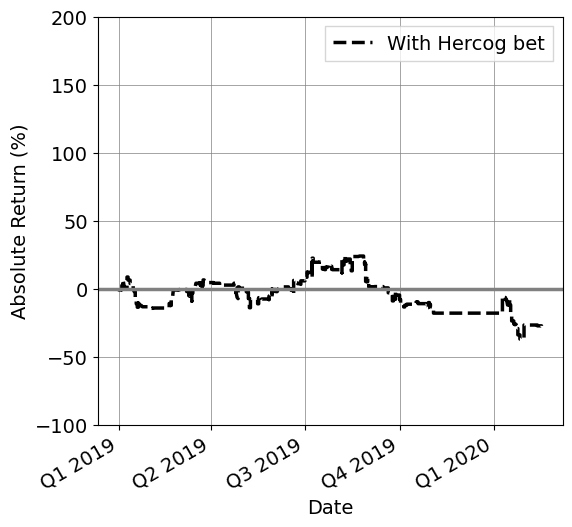

In [23]:
# Table 2 Average Odds 
params = fit_regression(train_set=fitset)
show_results(testset, estimated_probabilities='model_est_prob', params=params, odds="avg")
plot_results(testset)


    Bets considered (2 * Matches): 5156
    Number of bets placed: 312
    Mean overround (%): 6.46
    Absolute amount bet: 7.15
    Absolute return: 1.24
    ROI (%): 17.29
    

    Bets considered (2 * Matches): 5155
    Number of bets placed: 311
    Mean overround (%): 6.46
    Absolute amount bet: 6.77
    Absolute return: -0.50
    ROI (%): -7.36
    


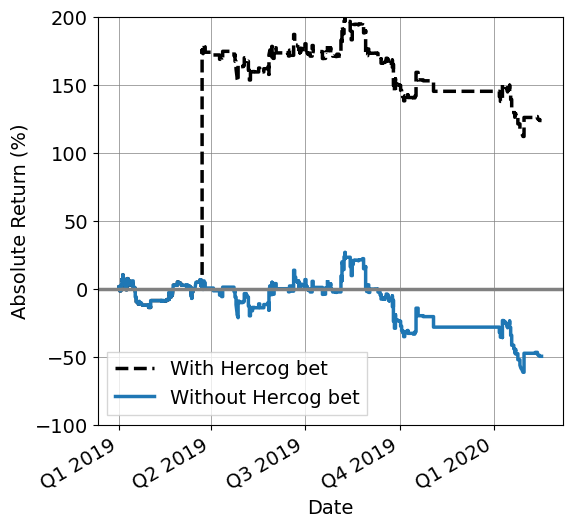

In [21]:
# Table 2 PM results and Figure 1a plot
params = fit_regression(rankdist=True, train_set=fitset)
show_results(testset, estimated_probabilities='model_est_prob', params=params, odds="b365", rankdist=True)
show_results(testset_no_hercog, estimated_probabilities='model_est_prob', params=params, odds="b365", rankdist=True)
plot_results(testset, testset_no_hercog)


    Bets considered (2 * Matches): 5156
    Number of bets placed: 276
    Mean overround (%): 6.46
    Absolute amount bet: 4.99
    Absolute return: 1.44
    ROI (%): 28.82
    

    Bets considered (2 * Matches): 5155
    Number of bets placed: 275
    Mean overround (%): 6.46
    Absolute amount bet: 4.60
    Absolute return: -0.29
    ROI (%): -6.31
    


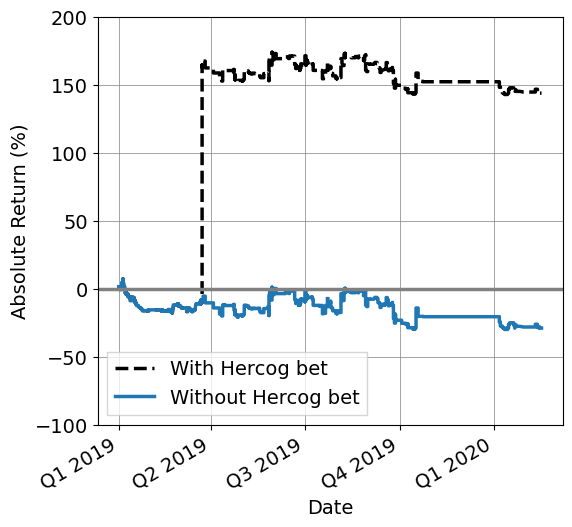

In [22]:
# Table 1/2 PM w/o RD results and Figure 1b plot
params = fit_regression(rankdist=False, train_set=fitset)
show_results(testset, estimated_probabilities='model_est_prob', params=params, odds="b365", rankdist=False)
show_results(testset_no_hercog, estimated_probabilities='model_est_prob', params=params, odds="b365", rankdist=False)
plot_results(testset, testset_no_hercog)

Bets considered (2 * Matches): 5189
Number of bets placed: 2350
Mean overround (%): -0.24448580402201056
Absolute amount bet: 76.62824688935302
Absolute return: 2.340716517895774
ROI (%): 3.054639265433856


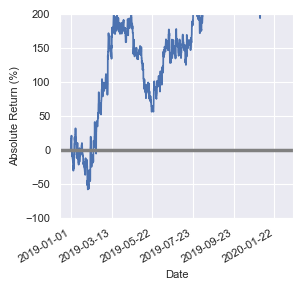

In [34]:
# Table 2 PM Best Odds results and Figure 2a plot
params = fit_regression(rankdist=True, train_set=fitset)
show_results(testset, estimated_probabilities='model_est_prob', params=params, odds="best")
plot_results()

In [26]:
testset[(testset['inverse_best'].isna())]

,index,match_id,player,date,year,tournament,rankdist,wikibuzz,inverse_b365,inverse_avg,inverse_best,outcome,error,tournament_and_year,overround_b365,overround_avg,overround_best
2871,18725,13918,Kristina Kucova,2019-07-15,2019.0,49,0.007736,0.395896,0.4,0.398406,NaN,0,-0.398406,233,0.066667,0.052001,-0.386503


In [31]:
# Using N=5188 Odds - Table 1 Disputed.
print("Match of note:")
print(testset[(testset['player'] == 'Kristina Kucova') & (testset['date'] == '2019-07-15')].to_string())

filtered_testset = testset[~((testset['player'] == 'Anastasia Potapova') & (testset['date'] == '2019-07-15'))].copy()
# Table 2 PM Best Odds results and Figure 2a plot
params = fit_regression(rankdist=True, train_set=fitset)
show_results(filtered_testset, estimated_probabilities='model_est_prob', params=params, odds="best")

Match of note:
      index  match_id           player        date    year  tournament  rankdist  wikibuzz  inverse_b365  inverse_avg  inverse_best  outcome     error  tournament_and_year  overround_b365  overround_avg  overround_best
2871  18725     13918  Kristina Kucova  2019-07-15  2019.0          49  0.007736  0.395896           0.4     0.398406           NaN        0 -0.398406                  233        0.066667       0.052001       -0.386503
Bets considered (2 * Matches): 5188
Number of bets placed: 2349
Mean overround (%): -0.23702401642438617
Absolute amount bet: 76.59972301019704
Absolute return: 2.3227464741583503
ROI (%): 3.032317067059287


In [5]:
# Table 5 Results Corrected.
def table_5_results(data, strict_inequality, range_1, range_2=None):
    if strict_inequality == 'yes':
        if (range_2 is None) and (isinstance(range_1, tuple)) and (len(range_1) == 2):
            lower_bound, upper_bound = range_1
            fitset = data[((data['inverse_avg'] > lower_bound) & (data['inverse_avg'] < upper_bound)) & (data['year'] < 2019)].copy()
            testset = data[((data['inverse_avg'] > lower_bound) & (data['inverse_avg'] < upper_bound)) & (data['year'] >= 2019)].copy()

        elif range_2 and (isinstance(range_1, tuple)) and (len(range_1) == 2) and (isinstance(range_2, tuple)) and (len(range_2) == 2):
            lower_bound_r1, upper_bound_r1 = range_1
            lower_bound_r2, upper_bound_r2 = range_2
            fitset = data[(((data['inverse_avg'] > lower_bound_r1) & (data['inverse_avg'] < upper_bound_r1)) | ((data['inverse_avg'] > lower_bound_r2) & (data['inverse_avg'] < upper_bound_r2))) & (data['year'] < 2019)].copy()
            testset = data[(((data['inverse_avg'] > lower_bound_r1) & (data['inverse_avg'] < upper_bound_r1)) | ((data['inverse_avg'] > lower_bound_r2) & (data['inverse_avg'] < upper_bound_r2))) & (data['year'] >= 2019)].copy()
        else:
            print("Param issue")
            return None

    elif strict_inequality == 'no':
        if (range_2 is None) and (isinstance(range_1, tuple)) and (len(range_1) == 2):
            lower_bound, upper_bound = range_1
            fitset = data[((data['inverse_avg'] >= lower_bound) & (data['inverse_avg'] <= upper_bound)) & (data['year'] < 2019)].copy()
            testset = data[((data['inverse_avg'] >= lower_bound) & (data['inverse_avg'] <= upper_bound)) & (data['year'] >= 2019)].copy()

        elif range_2 and (isinstance(range_1, tuple)) and (len(range_1) == 2) and (isinstance(range_2, tuple)) and (len(range_2) == 2):
            lower_bound_r1, upper_bound_r1 = range_1
            lower_bound_r2, upper_bound_r2 = range_2
            fitset = data[(((data['inverse_avg'] >= lower_bound_r1) & (data['inverse_avg'] <= upper_bound_r1)) | ((data['inverse_avg'] >= lower_bound_r2) & (data['inverse_avg'] <= upper_bound_r2))) & (data['year'] < 2019)].copy()
            testset = data[(((data['inverse_avg'] >= lower_bound_r1) & (data['inverse_avg'] <= upper_bound_r1)) | ((data['inverse_avg'] >= lower_bound_r2) & (data['inverse_avg'] <= upper_bound_r2))) & (data['year'] >= 2019)].copy()
        else:
            print("Param issue")
            return None
    elif strict_inequality == 'rrs_half_strict':
        if (range_2 is None) and (isinstance(range_1, tuple)) and (len(range_1) == 2):
            lower_bound, upper_bound = range_1
            fitset = data[((data['inverse_avg'] >= lower_bound) & (data['inverse_avg'] < upper_bound)) & (data['year'] < 2019)].copy()
            testset = data[((data['inverse_avg'] >= lower_bound) & (data['inverse_avg'] < upper_bound)) & (data['year'] >= 2019)].copy()

        elif range_2 and (isinstance(range_1, tuple)) and (len(range_1) == 2) and (isinstance(range_2, tuple)) and (len(range_2) == 2):
            lower_bound_r1, upper_bound_r1 = range_1
            lower_bound_r2, upper_bound_r2 = range_2
            fitset = data[(((data['inverse_avg'] >= lower_bound_r1) & (data['inverse_avg'] < upper_bound_r1)) | ((data['inverse_avg'] >= lower_bound_r2) & (data['inverse_avg'] < upper_bound_r2))) & (data['year'] < 2019)].copy()
            testset = data[(((data['inverse_avg'] >= lower_bound_r1) & (data['inverse_avg'] < upper_bound_r1)) | ((data['inverse_avg'] >= lower_bound_r2) & (data['inverse_avg'] < upper_bound_r2))) & (data['year'] >= 2019)].copy()
        else:
            print("Param issue")
            return None

    testset.dropna(subset=['inverse_b365'], inplace=True)
    formula = 'outcome ~ inverse_avg + wikibuzz'
    results = smf.ols(formula, data=fitset).fit(cov_type='cluster', cov_kwds={'groups': fitset['match_id']})
    params = results.params
    return show_results(testset, params=params, estimated_probabilities='model_est_prob', odds="b365", rankdist=False)

In [15]:
# RRS INCORRECT Results Column I: p∈(0,0.2)∪[0.8,1)
print("Incorrect with p∈(0,0.2)∪ [ 0.8,1):\n")
table_5_results(strict_inequality='rrs_half_strict', data=original_df, range_1=(0,0.2), range_2=(0.8,1))
# RRS Corrected Results Column I: p∈(0,0.2)∪(0.8,1)
print("\nCorrect with p∈(0,0.2)∪(0.8,1):\n")
table_5_results(strict_inequality='yes', data=original_df, range_1=(0,0.2), range_2=(0.8,1))

Incorrect with p∈(0,0.2)∪ [ 0.8,1):

Bets considered (2 * Matches): 732
Number of bets placed: 4
Mean overround (%): 5.710444721640053
Absolute amount bet: 0.04969291170362812
Absolute return: -0.0015019938248839598
ROI (%): -3.022551453297706

Correct with p∈(0,0.2)∪(0.8,1):

Bets considered (2 * Matches): 702
Number of bets placed: 7
Mean overround (%): 5.701494162137561
Absolute amount bet: 0.17916663264687654
Absolute return: -0.06056551760311341
ROI (%): -33.804016243629086


In [8]:
# RRS CORRECT Results Column II: p∈(0,0.4)∪(0.6,1)
table_5_results(strict_inequality='yes', data=original_df, range_1=(0,0.4), range_2=(0.6,1))


    Bets considered (2 * Matches): 3459
    Number of bets placed: 87
    Mean overround (%): 6.18
    Absolute amount bet: 1.03
    Absolute return: 0.01
    ROI (%): 0.81
    


,match_id,player,date,year,tournament,rankdist,wikibuzz,inverse_b365,inverse_avg,inverse_best,outcome,error,tournament_and_year,overround_b365,overround_avg,overround_best,model_est_prob,kelly_betsize,PnL
15854,1981,Petra Kvitova,2019-01-01,2019.0,16,-0.115079,-0.214383,0.833333,0.806452,0.781250,1,0.193548,207,0.064280,0.052757,0.003472,0.777819,0.0,0.0
15855,1980,Veronika Kudermetova,2019-01-01,2019.0,67,0.016291,1.875280,0.266667,0.257069,0.226757,1,0.742931,246,0.066667,0.050720,-0.021363,0.240698,0.0,0.0
15857,1988,Anastasija Sevastova,2019-01-01,2019.0,16,-0.062338,-0.923888,0.714286,0.694444,0.666667,1,0.305556,207,0.077922,0.055455,-0.036597,0.660373,0.0,0.0
15858,1977,Su-Wei Hsieh,2019-01-01,2019.0,2,-0.023950,0.310155,0.666667,0.645161,0.613497,1,0.354839,211,0.066667,0.051665,-0.006275,0.619506,0.0,0.0
15861,1983,Naomi Osaka,2019-01-01,2019.0,16,-0.195951,-1.646251,0.877193,0.862069,0.840336,1,0.137931,207,0.059011,0.049335,-0.003658,0.823664,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21035,4138,Saisai Zheng,2020-02-14,2020.0,74,-0.018254,-0.693147,0.714286,0.699301,0.671141,0,-0.699301,270,0.047619,0.056444,-0.021167,0.666863,0.0,-0.0
21036,4142,Elena Rybakina,2020-02-15,2020.0,50,0.007619,1.612937,0.636943,0.625000,0.591716,1,0.375000,267,0.058884,0.056034,-0.000121,0.608367,0.0,0.0
21037,4141,Magda Linette,2020-02-15,2020.0,74,-0.014286,0.517943,0.666667,0.657895,0.628931,1,0.342105,270,0.048346,0.054720,0.007719,0.633747,0.0,0.0
21038,4141,Patricia Maria Tig,2020-02-15,2020.0,74,0.014286,-0.517943,0.381679,0.396825,0.378788,0,-0.396825,270,0.048346,0.054720,0.007719,0.364320,0.0,-0.0


In [6]:
# RRS INCORRECT Results Column III: p∈[0.2,0.8)
print("Incorrect with p∈[0.2,0.8 ) :\n")
table_5_results(strict_inequality='rrs_half_strict', data=original_df, range_1=(0.2,0.8))
print("\nCorrect with p∈[0.2,0.8]:\n")
table_5_results(strict_inequality='no', data=original_df, range_1=(0.2,0.8))

Incorrect with p∈[0.2,0.8 ) :


    Bets considered (2 * Matches): 4424
    Number of bets placed: 363
    Mean overround (%): 6.58
    Absolute amount bet: 7.25
    Absolute return: 1.46
    ROI (%): 20.11
    

Correct with p∈[0.2,0.8]:


    Bets considered (2 * Matches): 4454
    Number of bets placed: 384
    Mean overround (%): 6.58
    Absolute amount bet: 7.95
    Absolute return: 1.44
    ROI (%): 18.13
    


,match_id,player,date,year,tournament,rankdist,wikibuzz,inverse_b365,inverse_avg,inverse_best,outcome,error,tournament_and_year,overround_b365,overround_avg,overround_best,model_est_prob,kelly_betsize,PnL
15855,1980,Veronika Kudermetova,2019-01-01,2019.0,67,0.016291,1.875280,0.266667,0.257069,0.226757,1,0.742931,246,0.066667,0.050720,-0.021363,0.253163,0.000000,0.000000
15856,1979,Johanna Konta,2019-01-01,2019.0,16,0.139640,0.195659,0.500000,0.476190,0.454545,1,0.523810,207,0.081395,0.050903,0.010101,0.449812,0.000000,0.000000
15857,1988,Anastasija Sevastova,2019-01-01,2019.0,16,-0.062338,-0.923888,0.714286,0.694444,0.666667,1,0.305556,207,0.077922,0.055455,-0.036597,0.652540,0.000000,0.000000
15858,1977,Su-Wei Hsieh,2019-01-01,2019.0,2,-0.023950,0.310155,0.666667,0.645161,0.613497,1,0.354839,211,0.066667,0.051665,-0.006275,0.618920,0.000000,0.000000
15859,1982,Monica Niculescu,2019-01-01,2019.0,67,0.035354,1.049822,0.546448,0.558659,0.534759,1,0.441341,246,0.092896,0.053709,-0.004411,0.542238,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21039,4139,Ekaterina Alexandrova,2020-02-15,2020.0,50,0.089286,1.323982,0.500000,0.483092,0.454545,0,-0.483092,267,0.055556,0.054520,-0.019139,0.470641,0.000000,-0.000000
21040,4139,Kiki Bertens,2020-02-15,2020.0,50,-0.089286,-1.323982,0.555556,0.571429,0.526316,1,0.428571,267,0.055556,0.054520,-0.019139,0.525500,0.000000,0.000000
21041,4142,Maria Sakkari,2020-02-15,2020.0,50,-0.007619,-1.612937,0.421941,0.431034,0.408163,0,-0.431034,267,0.058884,0.056034,-0.000121,0.382591,0.000000,-0.000000
21042,4143,Kiki Bertens,2020-02-16,2020.0,50,-0.085000,-2.935837,0.636943,0.641026,0.621118,1,0.358974,267,0.058884,0.055963,0.007218,0.574600,0.000000,0.000000



    Bets considered (2 * Matches): 1697
    Number of bets placed: 263
    Mean overround (%): 7.01
    Absolute amount bet: 9.27
    Absolute return: 2.72
    ROI (%): 29.38
    


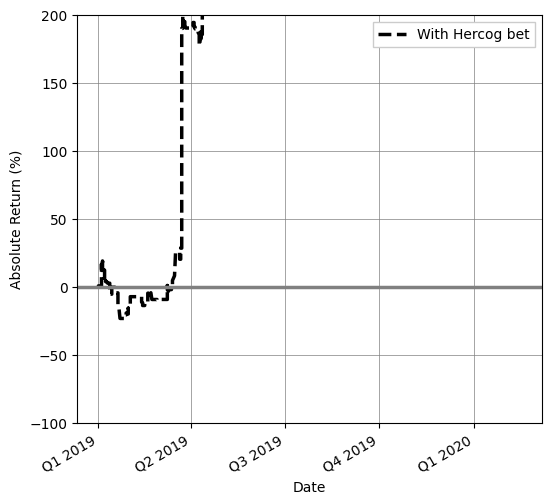

In [7]:
# RRS CORRECT Results Column IV: p∈[0.4,0.6]
testset = table_5_results(strict_inequality='no', data=original_df, range_1=(0.4,0.6))
plot_results(primary_data=testset)